# 네이버 영화 리뷰 감성 분석

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import urllib.request

# 전처리
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 모델링
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 임베딩 파라미터 분석
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 사전 학습된 Word2Vec 활용
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant

# 시각화
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_style("white")
sns.set_palette("Set2")

In [2]:
!pip install graphviz
!pip install pydot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# step 1) 데이터 준비 및 확인

In [40]:
dir_path=os.getenv('HOME')+'/aiffel/enode7/sentiment_classification/data/'

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/enode7/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/enode7/sentiment_classification/data/ratings_test.txt')

train_data.sample(5)

,id,document,label
33089,7937048,이런 어이없는 광고 따위 때문에 글쓰려고 로그인 하긴 첨이네..15세 관람가 인데 ...,0
31370,140596,뭘 애기하고 싶은 영화인지 모르겠다.....조금 웃기긴 했지만...저질,0
51970,8327505,"'사요나라, 한국 영화' ... 제발 우려먹기나 거저먹기는 이제 그만. 영화 감독이...",0
78222,9980895,잘만든 영화임. 처으부터 끝까지 흥미진진하게 봄.,1
41533,4280658,꿈과 현실이 만나면 이렇게 되는듯,1


# step 2) 도우미 함수
- 데이터 로드 함수
- 모델 생성 함수
- 학습 결과 시각화 함수

## 2-1. 데이터 로드 함수
- def `load_data(train, test, num_words=1000)`
    - 데이터 중복 제거
    - 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어 제거
    - word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - train_x, train_y, test_x, test_y, word_to_index 반환

In [4]:
tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

## 2-2. 모델 생성 함수
- def `create_models(num)`:
    - 하이퍼 파라미터 조정 후 재학습을 위한 모델 생성

In [215]:
# 빠른 재학습을 위한 모델 생성 도우미 함수
def create_models(num):
    if num == 1:
        vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
        word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

        # model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
        model1 = keras.Sequential()
        model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
        model1.add(keras.layers.LSTM(8))
        model1.add(keras.layers.Dense(8, activation='relu'))
        model1.add(keras.layers.Dense(1, activation='sigmoid'))

        model1.summary()
        model1.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])
        return model1
    if num == 2:
        vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
        word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

        model2 = keras.Sequential()
        model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
        model2.add(keras.layers.GlobalMaxPooling1D())
        model2.add(keras.layers.Dense(8, activation='relu'))
        model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

        model2.summary()
        model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
        return model2
    
    if num == 3:
        vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
        word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 
        model3 = keras.models.Sequential()
        model3.add(keras.layers.Embedding(vocab_size,word_vector_dim, input_shape=(None,)))
        model3.add(keras.layers.Conv1D(128,5, activation='relu'))
        model3.add(keras.layers.GlobalMaxPooling1D())
        model3.add(keras.layers.Dense(64, activation='relu'))
        model3.add(keras.layers.Dense(1, activation='sigmoid'))
        
        model3.summary()
        model3.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model3
    if num == 4:
        vocab_size = 10000
        word_vector_dim = 200

        # 모델 구성
        fine_model = keras.Sequential()
        fine_model.add(keras.layers.Embedding(vocab_size,
                                              word_vector_dim, 
                                              embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                              input_length=maxlen, 
                                              trainable=True))   # trainable을 True로 주면 Fine-tuning

        fine_model.add(keras.layers.LSTM(72, activation='relu'))
        fine_model.add(keras.layers.Dense(8, activation='relu'))
        fine_model.add(keras.layers.Dense(1, activation='sigmoid')) 

        fine_model.summary()
        # 학습의 진행
        fine_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return fine_model

In [7]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
# 전처리 속도가 너무 느려서 피클링
import pickle
with open('preprocessed_review.p', 'wb') as f:
    pickle.dump(x_train, f)
    pickle.dump(x_test, f)
    pickle.dump(word_to_index, f)


np.save(y_train.npy', y_train)
np.save(os.getenv('HOME')+'/aiffel/enode7/sentiment_classification/data/y_test.npy', y_test)

In [ ]:
def unpikle():
    with open(dir_path+'preprocessed_review.p', 'rb') as f:
        x_train = pickle.load(f)
        x_test = pickle.load(f)
        word_to_index = pickle.load(f)

    y_train = np.load(dir_path+'y_train.npy')
    y_test = np.load(dir_path+'y_test.npy')


## 2-3. 학습 결과 시각화 함수
- def `show_us(history)`
    - `model.fit()`한 history 객체를 전달 받아  각 epoch 마다 정확도와 loss를 시각화

In [31]:
# 시각화 함수
def show_us(history):
    history_dict = history.history
    loss_dict = {'loss': history_dict['loss'], 'val_loss':history_dict['val_loss']}
    acc_dict = {'accuracy':history_dict['accuracy'],'val_accuracy':history_dict['val_accuracy']}
    
    print('Train Loss : {:.4f}  Validation Loss : {:.4f}'.format(loss_dict['loss'][-1],loss_dict['val_loss'][-1]))
    print('Train Accuracy : {:.4f}  Validation Accuracy : {:.4f}'.format(acc_dict['accuracy'][-1],acc_dict['val_accuracy'][-1]))
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    sns.set_theme(style="darkgrid")
    palette = sns.color_palette("mako_r", 2)
    sns.lineplot(data=loss_dict, palette=palette, ax=ax[0])
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    sns.lineplot(data=acc_dict, palette=palette, ax=ax[1])
    ax[1].set_title('Training and validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    plt.show()

## 2-4. 문장 인코딩, 디코딩 도우미 함수

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
# 디코딩 잘 되나 확인
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더빙 .. 진짜 짜증나네요 목소리
라벨:  0


# step3) 데이터 분석 및 가공
- 패딩 추가
    1. 데이터셋 내 문장 길이 분포 확인
    2. 적절한 최대 문장 길이 지정
    3. `keras.preprocessing.sequence.pad_sequences()`로 패딩 추가

In [12]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  12.806930515667634
문장길이 최대 :  95
문장길이 표준편차 :  10.399093335789471
pad_sequences maxlen :  33
전체 문장의 0.9347442139050574%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

# step4) 모델 구성 및 검증 데이터셋 구성

In [14]:
# 훈련용 데이터에서 검증용 데이터 분리
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 33)
(136182,)


## 4-1) 모델1 : RNN

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


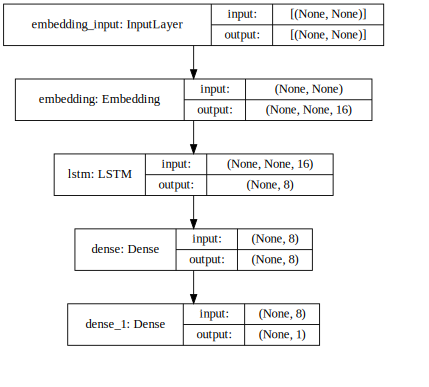

In [16]:
SVG(model_to_dot(model1, show_shapes=True,show_layer_names=True, dpi=65).create(prog='dot',format='svg'))

## 4-2) 모델2 : 1-D CNN

In [17]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


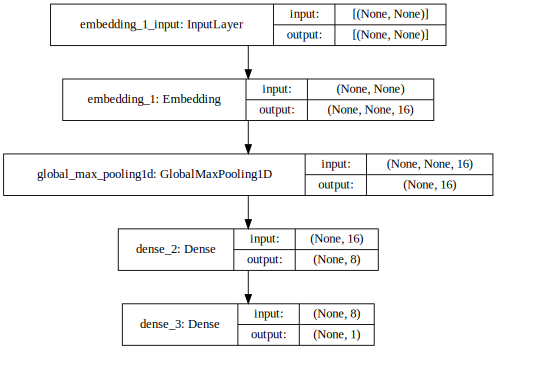

In [18]:
SVG(model_to_dot(model2, show_shapes=True,show_layer_names=True, dpi=65).create(prog='dot',format='svg'))

## 4-3) 모델3 : CNN

In [19]:
print(f'input train x shape : {partial_x_train.shape}')
print(f'input train y shape : {partial_y_train.shape}')

input train x shape : (136182, 33)
input train y shape : (136182,)


In [20]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 
model3 = keras.models.Sequential()
model3.add(keras.layers.Embedding(vocab_size,word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.Conv1D(128,5, activation='relu'))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(64, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         10368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 178,689
Trainable params: 178,689
Non-trainable params: 0
_________________________________________________________________


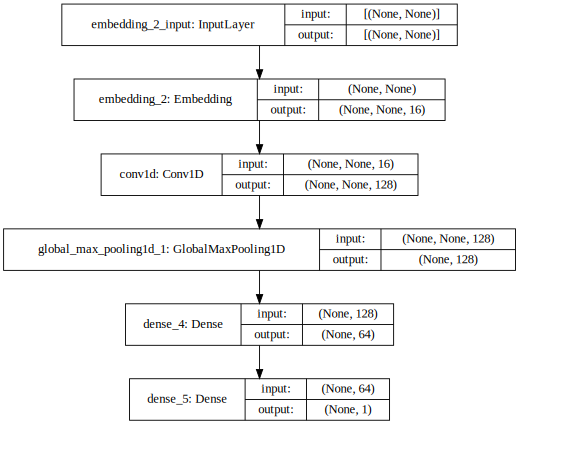

In [21]:
SVG(model_to_dot(model3, show_shapes=True,show_layer_names=True, dpi=65).create(prog='dot',format='svg'))

In [22]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# RNN 계열의 optimizer로 rmsporp이 좋다는 말을 들었다
# model3.compile(optimizer=optimizers.RMSprop(lr=0.001),
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# step5) 모델 훈련

## 5-1. EarlyStopping 및 ModelCheckpoint설정
- Validation Accuracy가 가장 높을 값일 때 멈추도록 설정
- Validation Accuracy가 이전보다 좋아진 경우에 모델 저장

In [23]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
mc = ModelCheckpoint('best_weight.h5', monitor='val_acc', mode='max',verbose=1, save_best_only=True)

In [24]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
model1 = create_models(1)
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[es,mc],
                    verbose=1)

result1 = model1.evaluate(x_test, y_test, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
266/266 [==============================] - 6s 12ms/step - loss: 0.6070 - accuracy: 0.6293 - val_loss: 0.3662 - val_accuracy: 0.8389
Epoch 2/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3377 - accuracy: 0.8567 - v

In [26]:
print(result1)

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3639 - accuracy: 0.8389


In [36]:
epochs=6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
model2 = create_models(2)
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[es,mc],
                    verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
266/266 [==============================] - 2s 5ms/step - loss: 0.6510 - accuracy: 0.6832 - val_loss: 0.4283 - val_accuracy: 0.8188
Epoch 2/6
266/266 [==============================] - 1s 4ms/step - loss: 0.3906 - accuracy: 0.8368 - val_

In [28]:
result2 = model2.evaluate(x_test, y_test, verbose=1)

1537/1537 [==============================] - 2s 2ms/step - loss: 0.3787 - accuracy: 0.8385


- epochs이 6일때 train accuracy와 validation accuracy 둘 다 결과가 가장 좋았다.

- 실제 Conv1D 계층을 넣은 모델이다.

In [29]:
epochs=20
model3 = create_models(3)
history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[es,mc],
                    verbose=1)
result3 = model3.evaluate(x_test, y_test, verbose=2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         10368     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 178,689
Trainable params: 178,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
266/266 [==============================] - 7s 14ms/step - loss: 0.5459 - accuracy: 0.7066 - val_loss: 0

# step6) 학습 결과 시각화

### LSTM 계층 모델

Train Loss : 0.3080  Validation Loss : 0.3457
Train Accuracy : 0.8694  Validation Accuracy : 0.8505


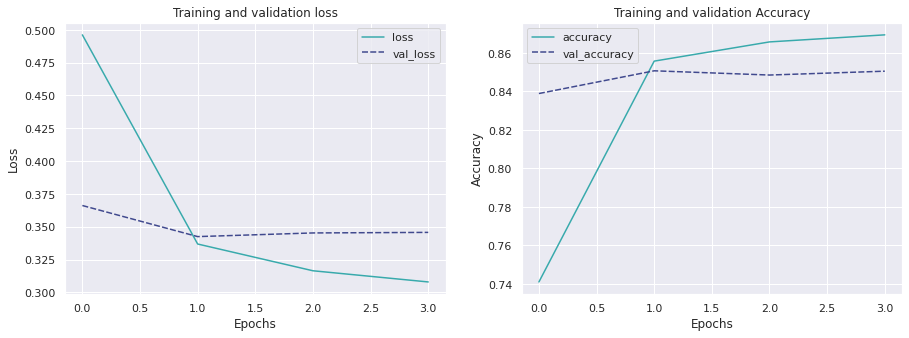

In [34]:
show_us(history1)

### MaxPooling 모델

Train Loss : 0.2636  Validation Loss : 0.3554
Train Accuracy : 0.8908  Validation Accuracy : 0.8500


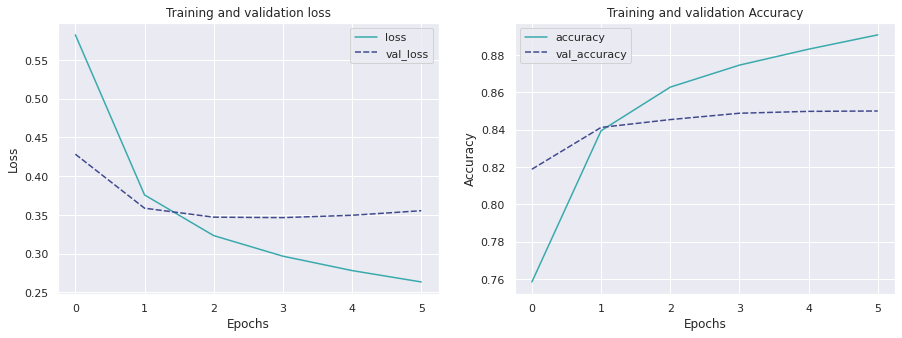

In [37]:
show_us(history2)

### 1D CNN 모델

Train Loss : 0.2308  Validation Loss : 0.3691
Train Accuracy : 0.9065  Validation Accuracy : 0.8460


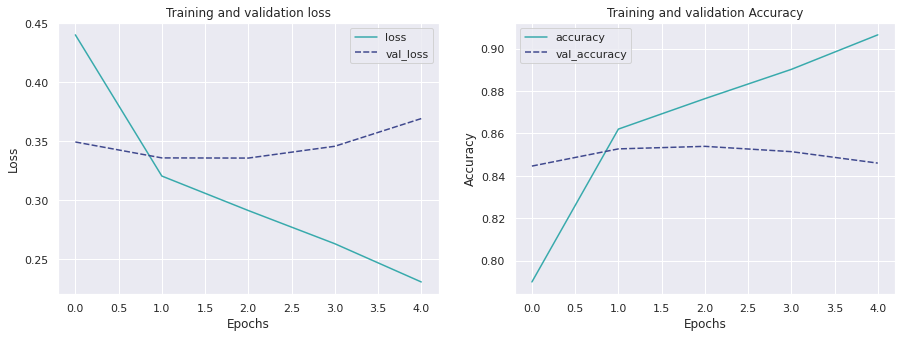

In [35]:
show_us(history3)

## 6-2. 새로운 문장 긍/부정 여부 판단

In [168]:
def predict_emotion(model, sentence):
    okt = Okt()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    sentence = okt.morphs(sentence, stem=True)
    sentence = str([word for word in sentence if not word in stopwords])
    
    encoded = get_encoded_sentence(sentence, word_to_index)
    while len(encoded) <= maxlen:
        encoded.append(3) # 3 == <PAD>
    score = float(model.predict([encoded]))
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰".format((1 - score) * 100))
    

In [169]:
for model in [model1, model2, model3]:
    predict_emotion(model, '시간 낭비임')

56.42% 확률로 부정 리뷰
59.85% 확률로 부정 리뷰
78.40% 확률로 부정 리뷰


In [187]:
for model in [model1, model2, model3]:
    predict_emotion(model, '뭐하나 부족함이 없는 작품..마지막장면의 아들을 향한 아버지의 눈빛에서 모든 감정이 읽혀져서 가장 기억에 오래 남네요.그 눈빛때문에 영화끝나고 엉엉 울었습니다')

94.68% 확률로 긍정 리뷰
59.85% 확률로 부정 리뷰
89.89% 확률로 부정 리뷰


In [188]:
for model in [model1, model2, model3]:
    predict_emotion(model, '기대안하고 ㅋㅋ봤는데 ㅋㅋ레이놀즠ㅋㅋ땜에 웃겨 죽는줄 ㅋㅋㅋ가볍게 보기에 좋음ㅋㅋㅋ중간에 ㅋㅋㅋ개터지는 부분 많음ㅋㅋㅋ')

89.32% 확률로 긍정 리뷰
59.85% 확률로 부정 리뷰
89.49% 확률로 부정 리뷰


In [190]:
for model in [model1, model2, model3]:
    predict_emotion(model, '노래도 좋고 배우들도 넘 귀엽고 재밌다. 여름 분위기 물씬 나는 유쾌한 영화. 이 영화를 보면 여름을 더 즐겁게, 열심히 보내고 싶어진다.')

90.76% 확률로 긍정 리뷰
59.85% 확률로 부정 리뷰
89.49% 확률로 부정 리뷰


- 확실히 LSTM을 사용한 모델이 감정 분석 정확도가 뛰어났다.
- 나머지 두 모델은 어떻게 하면 긍정 리뷰라고 해줄지 기대될 정도..

In [198]:
predict_emotion(model3, '박진감 넘치고 재밌었다.')

89.49% 확률로 부정 리뷰


# step7) 학습된 Embedding 레이어 분석
- 모델 중 Embedding 레이어의 파라미터들을 따로 저장

In [38]:
embedding_layers=[]
for model in [model1, model2, model3]:
    embedding_layers.append(model.layers[0])
weights = []
for layer in embedding_layers:
    weights.append(layer.get_weights()[0])
print(weights[0].shape) # (vocab_size, embedding_dimension)

(10000, 16)


In [ ]:
#학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = dir_path+'nav_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['대박']
vector

array([ 0.06831276, -0.09207106,  0.11604923, -0.07024089, -0.11716169,
       -0.09161986, -0.06468874,  0.019323  ,  0.10129273, -0.06294193,
        0.10306975, -0.01986909,  0.11626577,  0.09459221,  0.0809709 ,
        0.12256305], dtype=float32)

## 7-1. 긍정어 연관성

In [43]:
word_vectors.similar_by_word("대박")

[('아깝지', 0.9753324389457703),
 ('애잔한', 0.9643542766571045),
 ('슬프지만', 0.9635875821113586),
 ('재밌기만', 0.9630200862884521),
 ('재미있게', 0.9625986814498901),
 ('보석', 0.9620888829231262),
 ('땀', 0.9618150591850281),
 ('반해', 0.960966944694519),
 ('억압', 0.9608917832374573),
 ('가히', 0.9596177935600281)]

In [44]:
word_vectors.similar_by_word("볼")

[('마피아', 0.8979337215423584),
 ('괜찮았다', 0.8713160753250122),
 ('애정', 0.8677364587783813),
 ('박물관', 0.8549060821533203),
 ('흑형', 0.8428658246994019),
 ('어색하지', 0.8413121700286865),
 ('여왕', 0.8409032821655273),
 ('입체', 0.835097074508667),
 ('느끼게', 0.8342288732528687),
 ('잼있었는데', 0.8330966234207153)]

In [46]:
word_vectors.similar_by_word("신선한")

[('즐거웠다', 0.9377846717834473),
 ('되는데', 0.9349279999732971),
 ('감사하게', 0.9247840642929077),
 ('해봅니다', 0.9242801666259766),
 ('호불호', 0.9221433401107788),
 ('됬으면', 0.9202517867088318),
 ('깨달음', 0.9200471639633179),
 ('보고싶네요', 0.919702410697937),
 ('와도', 0.9137440919876099),
 ('훌륭함', 0.9108690023422241)]

In [47]:
word_vectors.similar_by_word("역작")

[('재밌당', 0.9837474226951599),
 ('김동완', 0.9836745858192444),
 ('재밌었고', 0.9798687100410461),
 ('아름다웠던', 0.9792598485946655),
 ('독특하고', 0.9787867069244385),
 ('이상형', 0.9769493341445923),
 ('슬프네요', 0.9765611290931702),
 ('진하게', 0.9760579466819763),
 ('펑펑', 0.9755608439445496),
 ('하모니', 0.975385844707489)]

In [87]:
word_vectors.similar_by_word("흥행")

[('됩니다', 0.8895398378372192),
 ('남아있는', 0.8495774865150452),
 ('빕니다', 0.8480660915374756),
 ('눈물난다', 0.8320838809013367),
 ('장편', 0.8262819647789001),
 ('자아', 0.8218193054199219),
 ('깊었던', 0.8214067220687866),
 ('여태껏', 0.8205358982086182),
 ('다시금', 0.8198398351669312),
 ('미치도록', 0.8166539669036865)]

## 7-2 부정어 연관성

In [45]:
word_vectors.similar_by_word("최악")

[('없구', 0.984233558177948),
 ('오글거려', 0.9809844493865967),
 ('이상해서', 0.9808022975921631),
 ('노잼', 0.980696439743042),
 ('졸았다', 0.9805079698562622),
 ('만드냐', 0.9797564744949341),
 ('재미없네', 0.9794145822525024),
 ('만들겠다', 0.9793559312820435),
 ('접영', 0.9792845249176025),
 ('흥미롭지', 0.9778022766113281)]

In [48]:
word_vectors.similar_by_word("노잼")

[('이상해서', 0.9874067306518555),
 ('개그맨', 0.98728346824646),
 ('발성', 0.9872792959213257),
 ('최악', 0.980696439743042),
 ('이상해', 0.9796851277351379),
 ('만드는지', 0.9792374968528748),
 ('보겠음', 0.9789784550666809),
 ('썼나', 0.9787105321884155),
 ('웃기지도', 0.9780599474906921),
 ('흥미롭지', 0.9779815673828125)]

In [90]:
word_vectors.similar_by_word("억지")

[('어이없고', 0.972498893737793),
 ('아까워서', 0.9610217213630676),
 ('재미없다', 0.9602510929107666),
 ('만들겠다', 0.9601000547409058),
 ('실망했다', 0.9599971175193787),
 ('최악', 0.9586231708526611),
 ('재미없네', 0.9578620195388794),
 ('같지도', 0.9568795561790466),
 ('썼나', 0.9567750692367554),
 ('발연기', 0.9563157558441162)]

In [91]:
word_vectors.similar_by_word("낭비")

[('김준호', 0.9818074107170105),
 ('김대희', 0.9749566316604614),
 ('아깝고', 0.9723896384239197),
 ('짜증', 0.9715514183044434),
 ('답답', 0.9706543684005737),
 ('흥미롭지', 0.9698517322540283),
 ('귀신', 0.9685678482055664),
 ('아까', 0.9678096771240234),
 ('만큼도', 0.9669404625892639),
 ('재미없다', 0.9660430550575256)]

- 긍정어, 부정어 둘 다 꽤 잘 맵핑된 것 같다.
- 부정어에 '에릭'이나 개그맨 이름이 종종 나오는데 개인적으로 이유가 무엇일지 궁금하다.

In [93]:
word_vectors.similar_by_word("김대희")

[('낭비', 0.9749566316604614),
 ('도무지', 0.9718021154403687),
 ('아까', 0.9638904333114624),
 ('불과', 0.9637704491615295),
 ('깝', 0.9630115032196045),
 ('흥미롭지', 0.9620776772499084),
 ('김준호', 0.9602026343345642),
 ('마이너스', 0.9587829113006592),
 ('모르겟고', 0.9586681127548218),
 ('난국', 0.9585113525390625)]

# step8) 한국어 Word2Vec 임베딩으로 성능 개선

## 8-0. Vocab 사용을 위해 gensim 다운그레이드

In [ ]:
!pip install --upgrade gensim==3.8.1

In [49]:
!pip list | grep gensim

gensim                        3.8.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 8-1. 한국어 Word2Vec 다운

In [50]:
!ls -al sentiment_classification/data

total 243852
drwxr-xr-x 4 root root     4096 Aug 12 10:51 .
drwxr-xr-x 4 root root     4096 Aug 12 10:51 ..
lrwxrwxrwx 1 root root       50 Aug 11 19:37 GoogleNews-vectors-negative300.bin.gz -> /aiffel/data/GoogleNews-vectors-negative300.bin.gz
drwxr-xr-x 2 root root     4096 Aug 12 08:27 .ipynb_checkpoints
-rw------- 1 root root 50697568 Dec 21  2016 ko.bin
-rw------- 1 root root 85362829 Dec 21  2016 ko.tsv
-rw-r--r-- 1 root root 80596565 Aug 12 08:34 ko.zip
-rw-r--r-- 1 root root  2028066 Aug 12 11:18 nav_word2vec.txt
-rw-r--r-- 1 root root  7838378 Aug 12 10:50 preprocessed_review.p
drwxr-xr-x 3 root root     4096 Aug 12 08:00 pretrained
-rwxr-xr-x 1 root root  4893335 Jul  6 03:16 ratings_test.txt
-rwxr-xr-x 1 root root 14628807 Jul  6 03:16 ratings_train.txt
-rw-r--r-- 1 root root  2057518 Aug 11 19:32 word2vec.txt
-rw-r--r-- 1 root root   393384 Aug 12 10:50 y_test.npy
-rw-r--r-- 1 root root  1169584 Aug 12 10:50 y_train.npy


## 8-2. 사전 학습된 한국어  Word2Vec 모델 사용

In [10]:
koword2vec_path = os.getenv('HOME')+'/aiffel/enode7/sentiment_classification/data/ko.bin'
koword2vec = Word2Vec.load(koword2vec_path)

In [51]:
vector = koword2vec['해산물']
vector

array([ 1.3300865 , -0.70137125,  0.3151821 ,  0.4135478 ,  0.8475367 ,
        0.18930033,  0.67249817, -0.02330537,  0.1058352 , -0.44736326,
        1.2663724 ,  0.5302018 , -0.5853249 , -0.38746947, -0.2261098 ,
        0.16653797, -0.3869417 ,  0.2020027 , -0.22752908, -0.90574646,
       -0.60779965,  0.65778077,  0.43298417, -0.33474898, -0.509899  ,
       -0.7520016 ,  0.71423244, -0.24393877, -0.33947507, -0.50915396,
       -0.32689592,  0.03719105, -0.1446624 ,  0.34073737, -0.20699415,
       -0.7795424 ,  0.21596694,  0.08077102,  0.03317945,  0.95000273,
       -0.69421893,  0.7992769 ,  0.25610602, -0.68878144,  0.54442817,
        0.5142195 ,  0.34343052, -0.84814304, -0.00331079,  0.814457  ,
        0.5163203 ,  0.8377619 , -0.92593044, -1.0905721 , -1.3699466 ,
       -0.7326797 , -0.6161057 , -0.6503584 , -0.36550024, -1.2844331 ,
       -0.0402385 ,  0.4388169 , -0.52494925, -0.5788641 ,  0.07354188,
        0.9250635 ,  0.89350903,  0.57776064,  0.20878994,  0.85

## 8-3. 사전 학습된 Word2Vec의 연관어 성능
- 위키백과를 기준으로 학습된 모델이기 때문에 리뷰에서 자주 사용되는 단어가 없는 경우가 있다. ex) 노잼
- 보통 평가에만 쓰이는 단어가 너무 다양한 범위의 단어와 벡터 공간 상에서 가까이 존재한다.

In [55]:
koword2vec.similar_by_word("최악")

[('초유', 0.546215832233429),
 ('최대', 0.4657382071018219),
 ('대공황', 0.4530748426914215),
 ('최고', 0.4529539942741394),
 ('최장', 0.4382264018058777),
 ('역전', 0.43632203340530396),
 ('최하위', 0.42039841413497925),
 ('여파', 0.4164554476737976),
 ('불황', 0.4069921672344208),
 ('추돌', 0.40534573793411255)]

In [57]:
koword2vec.similar_by_word("충격")

[('자극', 0.6292071342468262),
 ('악영향', 0.6289603114128113),
 ('고통', 0.6218981742858887),
 ('타격', 0.6169512271881104),
 ('영향', 0.599372148513794),
 ('감명', 0.5776066184043884),
 ('불쾌감', 0.562659502029419),
 ('반향', 0.5443421006202698),
 ('상처', 0.5426946878433228),
 ('손실', 0.5262940526008606)]

In [58]:
koword2vec.similar_by_word("흥행")

[('대성공', 0.5648161172866821),
 ('매출', 0.548312246799469),
 ('시청률', 0.5455290079116821),
 ('영화계', 0.5239896774291992),
 ('상영', 0.5163764953613281),
 ('판매량', 0.5056595206260681),
 ('관객', 0.49975186586380005),
 ('성공', 0.4990675747394562),
 ('상업적', 0.4922037124633789),
 ('공연', 0.48489463329315186)]

In [58]:
koword2vec.similar_by_word("감동")

[('대성공', 0.5648161172866821),
 ('매출', 0.548312246799469),
 ('시청률', 0.5455290079116821),
 ('영화계', 0.5239896774291992),
 ('상영', 0.5163764953613281),
 ('판매량', 0.5056595206260681),
 ('관객', 0.49975186586380005),
 ('성공', 0.4990675747394562),
 ('상업적', 0.4922037124633789),
 ('공연', 0.48489463329315186)]

### 같은 단어 두 개의 Word2Vec에서 비교

In [91]:
word_vectors.similar_by_word("낭비")

[('김준호', 0.9818074107170105),
 ('김대희', 0.9749566316604614),
 ('아깝고', 0.9723896384239197),
 ('짜증', 0.9715514183044434),
 ('답답', 0.9706543684005737),
 ('흥미롭지', 0.9698517322540283),
 ('귀신', 0.9685678482055664),
 ('아까', 0.9678096771240234),
 ('만큼도', 0.9669404625892639),
 ('재미없다', 0.9660430550575256)]

In [95]:
koword2vec.similar_by_word("낭비")

[('소모', 0.6752241253852844),
 ('절약', 0.6708904504776001),
 ('절감', 0.6346127986907959),
 ('지출', 0.5851995944976807),
 ('부담', 0.578451931476593),
 ('최소화', 0.5538947582244873),
 ('바닥나', 0.5429131388664246),
 ('고갈', 0.5400604009628296),
 ('삭감', 0.5259852409362793),
 ('인건비', 0.523245096206665)]

## 8-4. 사전 학습된 Word2Vec 기반 모델 학습
- 사전 학습된 Word2Vec에서 영화 리뷰에서 사용된 단어별 행렬 만들기

In [53]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in koword2vec:
        embedding_matrix[i] = koword2vec[index_to_word[i]]

In [218]:
vocab_size = 10000
word_vector_dim = 200

# 모델 구성
fine_model = keras.Sequential()
fine_model.add(keras.layers.Embedding(vocab_size,
                                      word_vector_dim, 
                                      embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                      input_length=maxlen, 
                                      trainable=True))   # trainable을 True로 주면 Fine-tuning

fine_model.add(keras.layers.LSTM(72, activation='relu'))
fine_model.add(keras.layers.Dense(8, activation='relu'))
fine_model.add(keras.layers.Dense(1, activation='sigmoid')) 

fine_model.summary()
# 학습의 진행
fine_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 33, 200)           2000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 72)                78624     
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 584       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 2,079,217
Trainable params: 2,079,217
Non-trainable params: 0
_________________________________________________________________


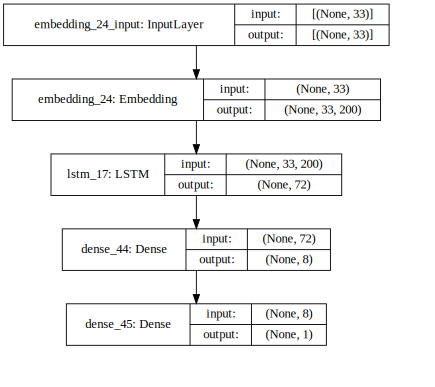

In [219]:
SVG(model_to_dot(fine_model, show_shapes=True,show_layer_names=True, dpi=65).create(prog='dot',format='svg'))

In [199]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc2 = ModelCheckpoint('pretrained_weight.h5', monitor='val_acc', mode='max',verbose=1, save_best_only=True)

In [216]:
epochs=20
fine_model = create_models(4)
fine_history = fine_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[es2,mc2],
                    verbose=1)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 33, 200)           2000000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 72)                78624     
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 584       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 2,079,217
Trainable params: 2,079,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
266/266 [==============================] - 18s 64ms/step - loss: 0.6326 - accuracy: 0.6175 - val_loss: 0.4244 - val_accuracy: 0.8057
Epoch 2/20
266/266 [==============================] - 16s 62ms/step - loss: 0.4197 - accuracy: 0.

## 8-5. 모델 평가

In [217]:
# 테스트셋을 통한 모델 평가
fine_results = fine_model.evaluate(x_test,  y_test, verbose=2)
print(fine_results)

1537/1537 - 8s - loss: 0.3496 - accuracy: 0.8512
[0.34958934783935547, 0.851150393486023]


Train Loss : 0.2516  Validation Loss : 0.3361
Train Accuracy : 0.8937  Validation Accuracy : 0.8546


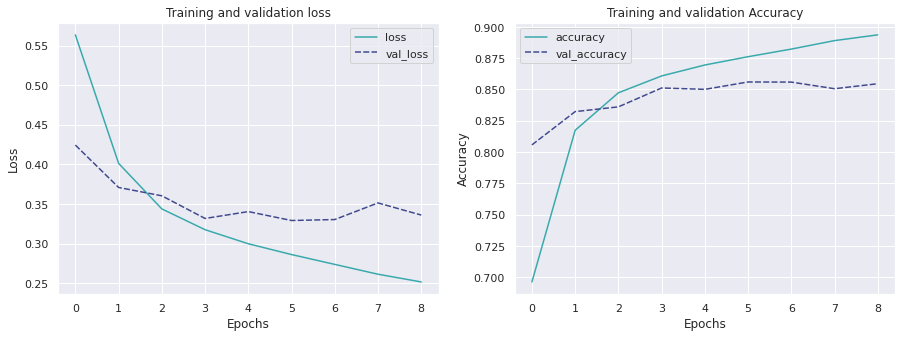

In [220]:
show_us(fine_history)

- Train Accuracy와 Validation Accuracy가 85% 이상 나왔다.

## 8-6. 전이학습 후 결과
- 전이 학습한 Embedding 레이어의 가중치를 저장하고 새롭게 학습된 Word2Vec 으로 단어간 유사성을 확인해보자.

In [ ]:
embedding_layer=fine_model.layers[0]
fine_weights = embedding_layer.get_weights()[0]
print(fine_weights[0].shape) # (vocab_size, embedding_dimension)
fine_word2vec_path = dir_path+'fine_word2vec.txt'
with open(fine_word2vec_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
    vectors = fine_weights
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))

In [100]:
fine_word_vectors = Word2VecKeyedVectors.load_word2vec_format(fine_word2vec_path, binary=False)

In [101]:
fine_word_vectors.similar_by_word("대박")

[('당당히', 0.5191193222999573),
 ('해학', 0.47902533411979675),
 ('첫사랑', 0.4744148254394531),
 ('단연', 0.4740237891674042),
 ('ㅠㅠ', 0.4559360146522522),
 ('울림', 0.44840335845947266),
 ('여운', 0.4418393075466156),
 ('하이라이트', 0.4409647583961487),
 ('자칫', 0.4396534562110901),
 ('후편', 0.43106889724731445)]

### 같은 단어 연관성 비교

- 아까 영화 리뷰와 맞지 않았던 단어를 다시 보자.

In [124]:
word_vectors.similar_by_word("울림")

[('재밋네', 0.9859057664871216),
 ('헌신', 0.9856736660003662),
 ('~~^^', 0.9854410886764526),
 ('주옥', 0.9842020869255066),
 ('유쾌하다', 0.9831419587135315),
 ('기다리고', 0.9827318787574768),
 ('슬퍼요', 0.9818447828292847),
 ('고마워요', 0.9815157651901245),
 ('귀여워요', 0.9814049005508423),
 ('찾게', 0.9810928106307983)]

In [125]:
koword2vec.similar_by_word("울림")

[('음색', 0.6680917739868164),
 ('리듬', 0.6386824250221252),
 ('선율', 0.6064305901527405),
 ('음빛깔', 0.6063597202301025),
 ('저음', 0.6059113144874573),
 ('창법', 0.575785756111145),
 ('트럼펫', 0.5727246999740601),
 ('목관', 0.5687721967697144),
 ('건반', 0.5667521953582764),
 ('질감', 0.5458199381828308)]

- 영화 리뷰에 완전히 부합하지는 않지만 fine tuning 이전 보다는 확실히 리뷰 다워졌다.

In [126]:
fine_word_vectors.similar_by_word("울림")

[('선율', 0.613617479801178),
 ('해학', 0.5526250600814819),
 ('색감', 0.508919358253479),
 ('울음', 0.5070587992668152),
 ('배꼽', 0.4977574348449707),
 ('백미', 0.494942843914032),
 ('여운', 0.49392712116241455),
 ('후편', 0.4889737069606781),
 ('탱고', 0.4796716272830963),
 ('중후', 0.4782445728778839)]

In [123]:
fine_word_vectors.similar_by_word("낭비")

[('고갈', 0.5641037821769714),
 ('부담', 0.5425623655319214),
 ('비용', 0.4881782531738281),
 ('부실', 0.48487651348114014),
 ('모자라', 0.478725790977478),
 ('스트레스', 0.4689067006111145),
 ('문제', 0.459914892911911),
 ('여유', 0.45892950892448425),
 ('남발', 0.4565277099609375),
 ('과잉', 0.4528103470802307)]

- 아직 영화리뷰 분석에 최적화된 정도가 낮아서 적절하지 않은 단어들이 가깝게 나오기도 한다.

In [129]:
vecs = [(word_vectors,'영화로만'), (koword2vec,'위키로만'), (fine_word_vectors, '전이학습')]
test_words = ['재미','눈물','흥행','명작','심각', '최악','시간','울림']
for word in test_words:
    for wv, name in vecs:
        print(f'{name}에서 {word}와 가까운 단어',end=' ')
        wv.similar_by_word(word)[:5]

영화로만에서 재미와 가까운 단어 

[('작', 0.7298842668533325),
 ('지하철', 0.7180498838424683),
 ('나온', 0.7067513465881348),
 ('볼거', 0.7051318287849426),
 ('보입니다', 0.69635409116745)]

위키로만에서 재미와 가까운 단어 

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213)]

전이학습에서 재미와 가까운 단어 

[('취미', 0.5908895134925842),
 ('매력', 0.5209051966667175),
 ('흥미', 0.5053398609161377),
 ('유머', 0.5021570324897766),
 ('즐거움', 0.48166829347610474)]

영화로만에서 눈물와 가까운 단어 

[('멋짐', 0.9616162776947021),
 ('입니당', 0.958705723285675),
 ('김현주', 0.9517280459403992),
 ('싶어졌다', 0.9492244720458984),
 ('넘침', 0.94769287109375)]

위키로만에서 눈물와 가까운 단어 

[('땀', 0.6310575008392334),
 ('슬픔', 0.5787195563316345),
 ('이별', 0.5772002935409546),
 ('추억', 0.5725258588790894),
 ('한숨', 0.5546674728393555)]

전이학습에서 눈물와 가까운 단어 

[('땀', 0.6158510446548462),
 ('슬픔', 0.5869154334068298),
 ('추억', 0.5838078260421753),
 ('이별', 0.5773792266845703),
 ('슬프', 0.5604763627052307)]

영화로만에서 흥행와 가까운 단어 

[('됩니다', 0.8895398378372192),
 ('남아있는', 0.8495774865150452),
 ('빕니다', 0.8480660915374756),
 ('눈물난다', 0.8320838809013367),
 ('장편', 0.8262819647789001)]

위키로만에서 흥행와 가까운 단어 

[('대성공', 0.5648161172866821),
 ('매출', 0.548312246799469),
 ('시청률', 0.5455290079116821),
 ('영화계', 0.5239896774291992),
 ('상영', 0.5163764953613281)]

전이학습에서 흥행와 가까운 단어 

[('시청률', 0.5461490154266357),
 ('상영', 0.5104687213897705),
 ('영화계', 0.5058581233024597),
 ('성공', 0.4984830319881439),
 ('관객', 0.49257993698120117)]

영화로만에서 명작와 가까운 단어 

[('낮아서', 0.9773876667022705),
 ('굳', 0.9732784032821655),
 ('재밌는', 0.9732643961906433),
 ('보고싶네요', 0.972762942314148),
 ('고인', 0.9722486138343811)]

위키로만에서 명작와 가까운 단어 

[('걸작', 0.7933748364448547),
 ('작품', 0.7375749945640564),
 ('대작', 0.686141848564148),
 ('희극', 0.6746902465820312),
 ('희곡', 0.674653947353363)]

전이학습에서 명작와 가까운 단어 

[('걸작', 0.8030387163162231),
 ('대작', 0.7368746995925903),
 ('작품', 0.6799803972244263),
 ('희극', 0.6399794220924377),
 ('거장', 0.6029123663902283)]

영화로만에서 심각와 가까운 단어 

[('명화', 0.9575226306915283),
 ('상치', 0.9493702054023743),
 ('근래', 0.9452059864997864),
 ('잼있음', 0.9422772526741028),
 ('괜찮았음', 0.9371293783187866)]

위키로만에서 심각와 가까운 단어 

[('극심', 0.8198436498641968),
 ('격심', 0.6635507345199585),
 ('불안정', 0.6633630394935608),
 ('민감', 0.6586565971374512),
 ('빈번', 0.6537488698959351)]

전이학습에서 심각와 가까운 단어 

[('위험', 0.5840416550636292),
 ('불안', 0.5553780794143677),
 ('절실', 0.5464164614677429),
 ('강력', 0.5276475548744202),
 ('대단', 0.5125010013580322)]

영화로만에서 최악와 가까운 단어 

[('없구', 0.984233558177948),
 ('오글거려', 0.9809844493865967),
 ('이상해서', 0.9808022975921631),
 ('노잼', 0.980696439743042),
 ('졸았다', 0.9805079698562622)]

위키로만에서 최악와 가까운 단어 

[('초유', 0.546215832233429),
 ('최대', 0.4657382071018219),
 ('대공황', 0.4530748426914215),
 ('최고', 0.4529539942741394),
 ('최장', 0.4382264018058777)]

전이학습에서 최악와 가까운 단어 

[('최대', 0.45113712549209595),
 ('최고', 0.4243558347225189),
 ('긴박', 0.3956333100795746),
 ('추락', 0.393665075302124),
 ('하락', 0.38641592860221863)]

영화로만에서 시간와 가까운 단어 

[('지경', 0.8957328796386719),
 ('줄수', 0.8847212195396423),
 ('아깝다', 0.8775444030761719),
 ('끝남', 0.8746466040611267),
 ('모르겟고', 0.8739814162254333)]

위키로만에서 시간와 가까운 단어 

[('분간', 0.599348783493042),
 ('간격', 0.5879659652709961),
 ('일주일', 0.5773798227310181),
 ('장시간', 0.5595555305480957),
 ('기간', 0.5561516880989075)]

전이학습에서 시간와 가까운 단어 

[('일주일', 0.5631872415542603),
 ('기간', 0.554441511631012),
 ('며칠', 0.5455434918403625),
 ('시간대', 0.5396287441253662),
 ('속도', 0.5079134702682495)]

영화로만에서 울림와 가까운 단어 

[('재밋네', 0.9859057664871216),
 ('헌신', 0.9856736660003662),
 ('~~^^', 0.9854410886764526),
 ('주옥', 0.9842020869255066),
 ('유쾌하다', 0.9831419587135315)]

위키로만에서 울림와 가까운 단어 

[('음색', 0.6680917739868164),
 ('리듬', 0.6386824250221252),
 ('선율', 0.6064305901527405),
 ('음빛깔', 0.6063597202301025),
 ('저음', 0.6059113144874573)]

전이학습에서 울림와 가까운 단어 

[('선율', 0.613617479801178),
 ('해학', 0.5526250600814819),
 ('색감', 0.508919358253479),
 ('울음', 0.5070587992668152),
 ('배꼽', 0.4977574348449707)]

# 회고

 - 시간이 부족해서 다양한 모델 변경이나 하이퍼 파라미터 변경을 진행하지 못한 것 같아 아쉽다.
 - 전처리를 다양한 방식으로 시도해보고 그에 따른 실험 결과를 보고 싶다.
 - 효과적인 전이학습을 위한 다른 방식이 있는지 알아봐야겠다.